In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from collections import Counter


In [15]:
with open("data/training/text8_20m.txt") as f:
    text= f.read()
    
text[:100]

'anarchism originated as a term of abuse first used against early working class radicals including th'

**Text Preprocessing** 


In [16]:
words= text.split(" ")

words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

**Building the Vocabulary**

In [17]:
words_count= Counter(words).most_common(60000)

most_freq_words= [item for item, _ in words_count]

#assigning unique id to every word
word_idx= {word: i+1 for i, word in enumerate(most_freq_words)}
word_idx['<UNK>']= 0

#converting text to idx
text_idx= [word_idx.get(w, word_idx['<UNK>']) for w in words]

#add freq of unfrequent words
words_count.append(('UNK', text_idx.count(0)))

text_idx[:10]

[1336, 2862, 13, 7, 194, 2, 4067, 49, 60, 137]

**Generate training data**

In [18]:
def generate_training_pairs(words, C):
    training_pairs= []
    n= len(words)
    
    for i, center_word in enumerate(text_idx):
        start_idx= max(0, i-C)
        end_idx= min(n-1, i+C+1)
        
        for j in range(start_idx, end_idx):
            if j!=i: #skip center word
                training_pairs.append((center_word, words[j]))
    
    return training_pairs

C= 2

training_pairs= generate_training_pairs(text_idx, C)

training_pairs[:10]

[(1336, 2862),
 (1336, 13),
 (2862, 1336),
 (2862, 13),
 (2862, 7),
 (13, 1336),
 (13, 2862),
 (13, 7),
 (13, 194),
 (7, 2862)]

Calculate unigram and smoothed unigram distribution

In [19]:
import numpy as np
N= sum([c for _,c in words_count])
alpha= 3/4

unigram= {word: freq/N for word,freq in words_count}

unigram_sum= sum(u**alpha for u in unigram.values())

smoothed_unigram= {word: (uni**alpha)/unigram_sum for word, uni in unigram.items()}

unigram_table= np.array(list(smoothed_unigram.values()))


**Training Loop**

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from Skipgram import Skipgram
from NegativeSamplingLoss import NegativeSamplingLoss
import torch
import numpy as np
from alive_progress import alive_bar

def train_skipgram(dataset, vocab_size, unigram, embedding_dim, batch_size=64, epochs=5, learning_rate=0.01, num_negatives=20):
    
    dataloader= DataLoader(dataset, batch_size)
    
    model= Skipgram(vocab_size, embedding_dim)
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model= model.to(device)
    
    criterion= NegativeSamplingLoss()
    optim= Adam(model.parameters(), lr=learning_rate)
    
    
    for epoch in range(epochs):
        total_loss= 0
                
        with(alive_bar(len(dataloader), force_tty=True)) as bar:
            for center, contexts in dataloader:
                center, contexts = center.long(), contexts.long()
                center= center.to(device)
                contexts= contexts.to(device)
                
                #make sure batch_size is equal
                current_batch_size= len(center)
                
                #sample negatives from unigram
                negatives= torch.tensor(
                    np.random.choice(
                        vocab_size,
                        (current_batch_size, num_negatives),
                        p= unigram
                    ),
                    dtype=torch.long,
                    device=device
                )
                
                #forward pass
                positive_score, negative_score= model(center, contexts, negatives)
                
                loss= criterion(positive_score, negative_score)
                
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                total_loss+= loss.item()
                bar()
                
        print(f"Epoch {epoch+1}/{epochs} -- Loss: {total_loss/len(dataloader):.4F}")
    
    return model
            

**Training**

In [37]:
from SkipgramDataset import SkipgramDataset
import time

### Hyperparameters ###
EMBEDDING_DIM= 128
BATCH_SIZE= 512
EPOCHS= 5
LEARNIN_RATE= 0.001
NUM_NEGATIVES= 15
#######################

pairs= training_pairs
dataset= SkipgramDataset(pairs)
vocab_size= 60001

embedding_dim= 128

t0= time.time()
model = train_skipgram(dataset, vocab_size, unigram_table,
                       embedding_dim= EMBEDDING_DIM,
                       batch_size= BATCH_SIZE,
                       epochs= EPOCHS,
                       learning_rate=LEARNIN_RATE,
                       num_negatives=NUM_NEGATIVES)
t1= time.time()

#torch.save(model.state_dict(), 'model.pth')

print(f"Time: {t1-t0:.2F} seconds")


|▊⚠︎                                      | (!) 297/15625 [2%] in 13.7s (21.76/s)


KeyboardInterrupt: 

**Evaluation**

Calculate word embeddings for the evaluation words.

In [34]:
import pandas as pd

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# model = Skipgram(vocab_size, embedding_dim) 
# model.to(device)
# model.load_state_dict(torch.load('model.pth'))

model.eval()

wordsim353_df= pd.read_csv("data/evaluation/wordsim353.csv")

w1_embedding= wordsim353_df["W1 Embeddning"]= [model.embedding(torch.tensor(word_idx.get(w1)).to(device)).cpu().detach().numpy() if w1 in word_idx.keys() else None
                                 for w1 in wordsim353_df['Word 1']]

w2_embedding= wordsim353_df["W2 Embeddning"]= [model.embedding(torch.tensor(word_idx.get(w2)).to(device)).cpu().detach().numpy() if w2 in word_idx.keys() else None
                                 for w2 in wordsim353_df['Word 2']]

wordsim353_df['Cosine similarity']= [np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    if v1 is not None and v2 is not None else None
    for v1, v2 in zip(w1_embedding, w2_embedding)]

wordsim353_df=wordsim353_df.dropna(axis=0)

wordsim353_df.head()

,Word 1,Word 2,Human (mean),W1 Embeddning,W2 Embeddning,Cosine similarity
0,love,sex,6.77,"[0.1569589, -0.17230625, 0.16496423, 0.1681193...","[0.14207458, -0.14896418, 0.14856924, 0.146158...",0.998903
1,tiger,cat,7.35,"[0.13159403, -0.13909984, 0.121444516, 0.13380...","[0.14156282, -0.13849904, 0.1430537, 0.1372891...",0.998015
2,tiger,tiger,10.00,"[0.13159403, -0.13909984, 0.121444516, 0.13380...","[0.13159403, -0.13909984, 0.121444516, 0.13380...",1.000000
3,book,paper,7.46,"[0.20702599, -0.20106122, 0.19336763, 0.198390...","[0.16673861, -0.16610381, 0.18135922, 0.172691...",0.998962
4,computer,keyboard,7.62,"[0.15965901, -0.16700888, 0.15808117, 0.152309...","[0.09239234, -0.09823249, 0.0961571, 0.1005675...",0.997458


Compare inferred cosine similarity and human-assigned similarity using Spearman’s rank correlation coefficient.

In [35]:
from scipy.stats import spearmanr

cosine_sim= np.array(wordsim353_df['Cosine similarity'])
human_score= np.array(wordsim353_df['Human (mean)'])

spearman_coef= spearmanr(cosine_sim, wordsim353_df['Human (mean)'])

spearman_coef

SignificanceResult(statistic=-0.03218144596986976, pvalue=0.5644270069938524)

**Visualization**

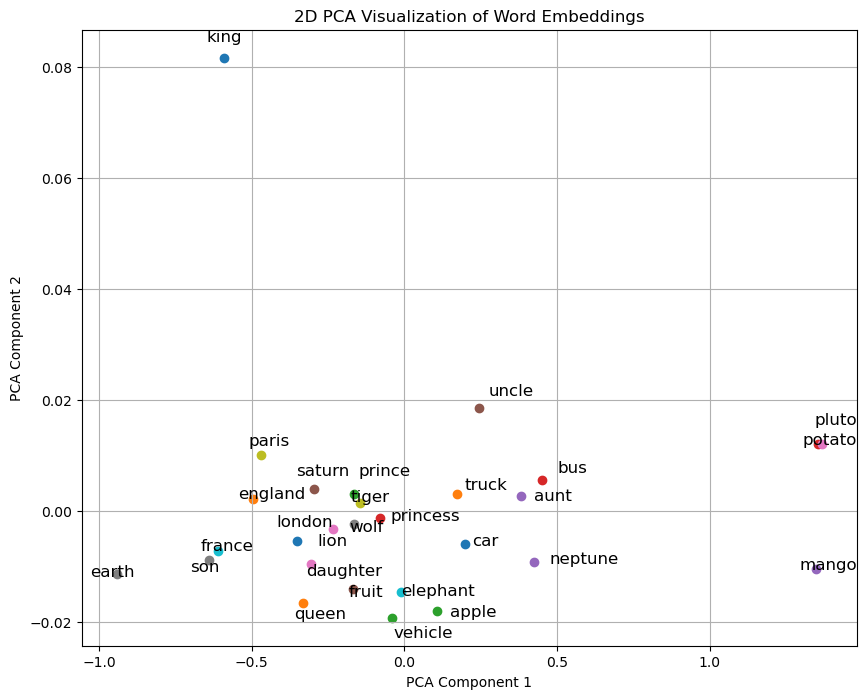

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from adjustText import adjust_text

def visualize_reduced_embeddings(reduced_embeddings, labels):

    plt.figure(figsize=(10, 8))
    
    texts = []  # List to store text objects for adjustment
    for i, word in enumerate(eval_words):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        text = plt.text(x + 0.1*x, y + 0.1*y, word, fontsize=12)  # Create a text object
        texts.append(text)  # Append the text object to the list

    adjust_text(texts)

    plt.title('2D PCA Visualization of Word Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()


eval_words = [
    "king", "queen", "prince", "princess", "aunt", "uncle", "daughter", "son",
    "paris", "france", "london", "england",
    "apple", "potato", "mango", "fruit",
    "lion", "wolf", "tiger", "elephant",
    "car", "truck", "vehicle", "bus",
    "neptune", "saturn", "pluto", "earth"
]

eval_words_embeddings= [model.embedding(torch.tensor(word_idx.get(w)).to(device)).cpu().detach().numpy()
                                 for w in eval_words] 


pca= PCA(n_components=2)

reduced_embeddings= pca.fit_transform(eval_words_embeddings) 
visualize_reduced_embeddings(reduced_embeddings, eval_words)